### Initially given dataset: https://www.kaggle.com/jessicali9530/celeba-dataset

### Dataset used from: https://susanqq.github.io/UTKFace/

#### Ensure GPU is used

Tensorflow-GPU: https://www.tensorflow.org/install/pip

In [5]:
# Ensure you have the latest TensorFlow gpu release installed.
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14721976764014567455
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4163895296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12777514387704419512
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Part 1 - Train GANs

## Original code (not used)

In [3]:
from os import listdir
import os
from numpy import asarray, savez_compressed
from PIL import Image
import mtcnn
from matplotlib import pyplot
import glob

Loaded:  (25, 200, 200, 3)


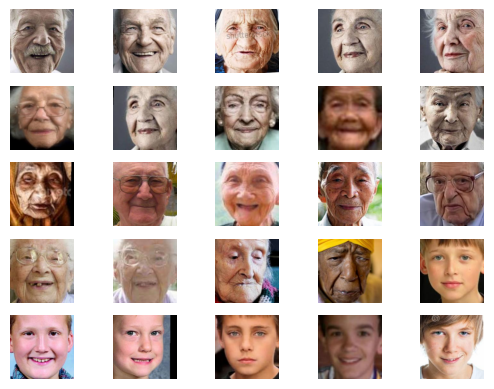

In [5]:
# load an image as an rgb numpy array 
def load_image(filename):
    # load image from file
    image = Image.open(filename)
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    return pixels

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # load the image
        pixels = load_image(directory+filename)
        # store
        faces.append(pixels)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)

# plot a list of loaded faces
def plot_faces(faces, n):

    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')

        pyplot.imshow(faces[i])
    pyplot.show()

directory = os.path.join("data/UTKFace/UTKFace/")
faces = load_faces(directory, 25)
print('Loaded: ', faces.shape)
plot_faces(faces, 5)

In [9]:
print(mtcnn.__version__)

0.1.0


In [10]:
from mtcnn.mtcnn import MTCNN

In [11]:
def extract_face(model, pixels, required_size=(80,80)):
    faces = model.detect_faces(pixels)

    if len(faces) == 0:
        return None

    x1, y1, width, height = faces[0]['box']
    x2, y2 = x1 + width, y1 + height
    face_pixels = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)

    return face_array

def load_faces(directory, n_faces):
    model = MTCNN()
    faces = list()
    for filename in listdir(directory):
        pixels = load_image(directory+filename)
        face = extract_face(model, pixels)
        if face is None:
            continue
        faces.append(face)

        print(len(faces), face.shape)

        if len(faces) >= n_faces:
            break
    return asarray(faces)

In [9]:
# directory = os.path.join('img_align_celeba/')
# all_faces = load_faces(directory, 1000)
# print('Loaded: ', all_faces.shape)
# savez_compressed('img_align_celeba.npz', all_faces)

In [11]:
# load and prepare training images
# def load_real_samples():
#     data = load('img_align_celeba.npz')
#     X = data['arr_0']
#     X = X.astype('float32')
#     X = (X - 127.5) / 127.5
#     return X

In [12]:
# EXTRACT FACES

"""

Load images, extract faces and save them to a new directory.

Dataset: https://www.kaggle.com/jessicali9530/celeba-dataset

Haarcascade models...
https://github.com/opencv/opencv/tree/master/data/haarcascades
"""


import cv2
import glob

face_cascade = cv2.CascadeClassifier('haarcascades_models/haarcascade_frontalface_default.xml')

#select the path
path = "data/*.*"
img_number = 1  #Start an iterator for image number.

for file in glob.glob(path):
    print(file)     #just stop here to see all file names printed
    img= cv2.imread(file, 1)  #now, we can read each file since we have the full path
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    try:
        for (x,y,w,h) in faces:
            roi_color = img[y:y+h, x:x+w] 
        resized = cv2.resize(roi_color, (128,128))
        cv2.imwrite("faces/"+str(img_number)+".jpg", resized)
    except:
        print("No faces detected")
    
    
    img_number +=1     

## Main train

In [6]:
from numpy import load
from numpy import zeros, ones 
from numpy.random import randn, randint

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

In [7]:
# Function to sample some random real images
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1)) # Class labels for real images are 1
    return X, y

# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Function to generate fake images using latent vectors
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples) #Generate latent points as input to the generator
    X = g_model.predict(x_input) #Use the generator to generate fake images
    y = zeros((n_samples, 1)) # Class labels for fake images are 0
    return X, y

In [8]:
# define the standalone discriminator model
# Input would be 128x128x3 images and the output would be a binary (using sigmoid)
#Remember that the discriminator is just a binary classifier for true/fake images.
def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 64x64
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [6]:
#Verify the model summary
test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr, to_file='disc_model.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

In [9]:
# define the standalone generator model
# Generator must generate 128x128x3 images that can be fed into the discriminator. 
# So, we start with enough nodes in the dense layer that can be gradually upscaled
#to 128x128x3. 
#Remember that the input would be a latent vector (usually size 100)
def define_generator(latent_dim):
	model = Sequential()
	# Define number of nodes that can be gradually reshaped and upscaled to 128x128x3
	n_nodes = 128 * 8 * 8 #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 128x128x3
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #tanh goes from [-1,1]
	return model

In [8]:
test_gen = define_generator(100)
print(test_gen.summary())
plot_model(test_gen, to_file='generator_model.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [10]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [10]:
test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())
plot_model(test_gan, to_file='combined_model.png', show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       1901059   
                                                                 
 sequential (Sequential)     (None, 1)                 602113    
                                                                 
Total params: 2,503,172
Trainable params: 1,901,059
Non-trainable params: 602,113
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
# Function to save Plots after every n number of epochs
def save_plot(examples, epoch, n=10):
    # scale images from [-1,1] to [0,1] so we can plot
    examples = (examples + 1) / 2.0

    for i in range(n * n):
        plt.subplot(n, n, 1 + 1)
        plt.axis('off')
        plt.imshow(examples[i])
    # save plot to a file so we can view how generated images evolved over epochs
    filename = 'training_data/images/generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [12]:
# Function to summarize performance periodically. 

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # Fetch real images
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real images - get accuracy
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # Generate fake images
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake images - get accuracy
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # Print discriminate accuracies on ral and fake images. 
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    # save generated images periodically using the save_plot function
    save_plot(x_fake, epoch)

    # save the generator model
    filename = 'training_data/models/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [13]:
# Function to plot discriminator and generator losses
def plot_losses(d_real_losses, d_fake_losses, g_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(d_real_losses, label='Discriminator Real Loss')
    plt.plot(d_fake_losses, label='Discriminator Fake Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.show()

In [14]:
# train the generator and discriminator by enumerating batches and epochs. 

# Lists to store losses for real and fake images in the discriminator, and generator losses
d_real_losses, d_fake_losses, g_losses = [], [], []

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=16):

    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2) #Disc. trained on half batch real and half batch fake images
    
    # enumerate epochs
    for i in range(n_epochs):
        # enumerate batches
        for j in range(bat_per_epo):
            # Fetch random 'real' images
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Train the discriminator using real images
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' images 
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Train the discriminator using fake images
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # Generate latent vectors as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Label generated (fake) mages as 1 to fool the discriminator 
            y_gan = ones((n_batch, 1))
            # Train the generator (via the discriminator's error)
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Append discriminator and generator losses
            d_real_losses.append(d_loss1)
            d_fake_losses.append(d_loss2)
            g_losses.append(g_loss)
            
            # Report disc. and gen losses. 
            print('Epoch no. >%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

# # size of the latent space
# latent_dim = 100
# # create the discriminator
# d_model = define_discriminator()
# # create the generator
# g_model = define_generator(latent_dim)
# # create the gan
# gan_model = define_gan(g_model, d_model)
# # load image data
# dataset = load_real_samples()
# # train model
# train(g_model, d_model, gan_model, dataset, latent_dim)

In [15]:
#Now that we defined all necessary functions, let us load data and train the GAN.
# Dataset from: https://susanqq.github.io/UTKFace/
import os
import numpy as np
import cv2
from PIL import Image
import random

n=5000 #Number of images to read from the directory. (For training)
SIZE = 128 #Resize images to this size
all_img_list = os.listdir('data/UTKFace/UTKFace/') #

dataset_list = random.sample(all_img_list, n) #Get n random images from the directory

#Read images, resize and capture into a numpy array
dataset = []
for img in dataset_list:
    temp_img = cv2.imread("data/UTKFace/UTKFace/" + img)
    if temp_img is None:
        print(f"Error reading image: {img}")
        continue  # Skip to the next iteration
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB) #opencv reads images as BGR so let us convert back to RGB
    temp_img = Image.fromarray(temp_img)
    temp_img = temp_img.resize((SIZE, SIZE)) #Resize
    dataset.append(np.array(temp_img))   

dataset = np.array(dataset) #Convert the list to numpy array

#Rescale to [-1, 1] - remember that the generator uses tanh activation that goes from -1,1
dataset = dataset.astype('float32')
	# scale from [0,255] to [-1,1]
dataset = (dataset - 127.5) / 127.5

# size of the latent space
latent_dim = 100
# create the discriminator using our pre-defined function
d_model = define_discriminator()
# create the generator using our pre-defined function
g_model = define_generator(latent_dim)
# create the gan  using our pre-defined function
gan_model = define_gan(g_model, d_model)

# train model
# train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50)

In [16]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

1/1 [==============================] - 1s 841ms/step
Epoch no. >1, 1/312, d1=0.681, d2=0.695, g=0.692
1/1 [==============================] - 0s 16ms/step
Epoch no. >1, 2/312, d1=0.615, d2=0.696, g=0.692
1/1 [==============================] - 0s 31ms/step
Epoch no. >1, 3/312, d1=0.533, d2=0.698, g=0.691
1/1 [==============================] - 0s 31ms/step
Epoch no. >1, 4/312, d1=0.419, d2=0.705, g=0.685
1/1 [==============================] - 0s 8ms/step
Epoch no. >1, 5/312, d1=0.177, d2=0.732, g=0.663
1/1 [==============================] - 0s 16ms/step
Epoch no. >1, 6/312, d1=0.064, d2=0.794, g=0.631
1/1 [==============================] - 0s 19ms/step
Epoch no. >1, 7/312, d1=0.025, d2=0.855, g=0.625
1/1 [==============================] - 0s 32ms/step
Epoch no. >1, 8/312, d1=0.037, d2=0.836, g=0.689
1/1 [==============================] - 0s 32ms/step
Epoch no. >1, 9/312, d1=0.169, d2=0.773, g=0.718
1/1 [==============================] - 0s 25ms/step
Epoch no. >1, 10/312, d1=0.125, d2=0.70

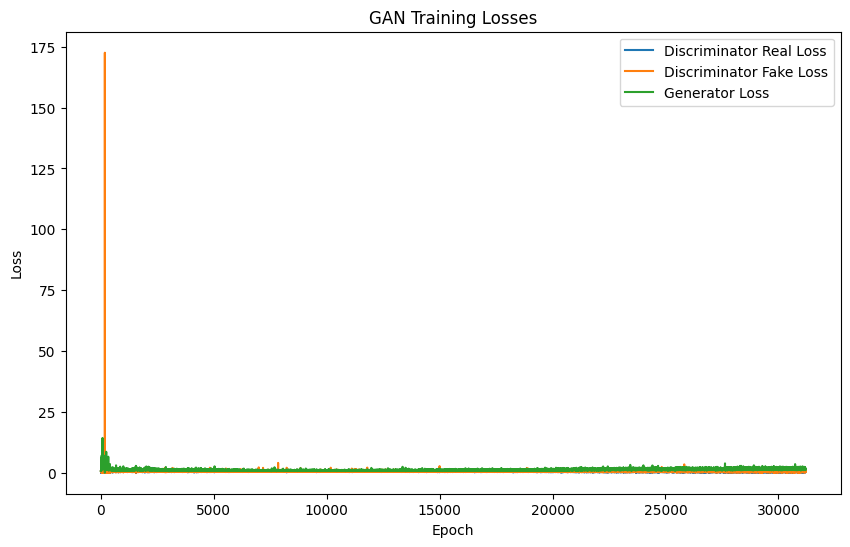

In [17]:
# Plot discriminator and generator losses
plot_losses(d_real_losses, d_fake_losses, g_losses)

# Part 2 - Generate Images from trained model

In [18]:
from numpy.random import randn
from keras.models import load_model
import matplotlib.pyplot as plt

In [19]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):

    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# create a plot of generated images
def plot_generated(examples, n):
    plt.figure(figsize=(16,16))
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.savefig('generated_faces.png')
    plt.close()
    # plt.show()

# load model
model = load_model('training_data/models/generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)

1/1 [==============================] - 1s 763ms/step


# Part 3 - Interpolate Between Generated Faces

In [20]:
from numpy import asarray
from numpy.random import randn
from numpy import linspace

1/1 [==============================] - 0s 283ms/step


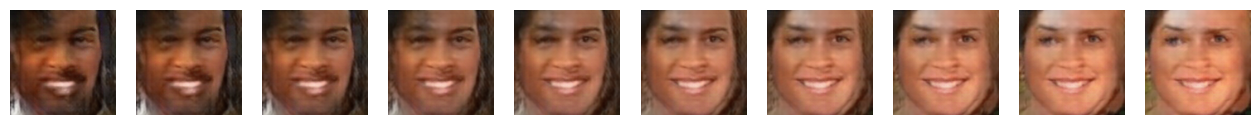

In [97]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
    plt.figure(figsize=(16,16))
    # plot images
    for i in range(n):
        # define subplot
        plt.subplot(1, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

# load model
model = load_model('training_data/models/generator_model_100.h5')
# generate points in latent space. generating 100 latent vectors
pts = generate_latent_points(100, 100)
latent_points = generate_latent_points(100, 25)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

#### Generate the final latent points to use

In [33]:
from numpy import vstack

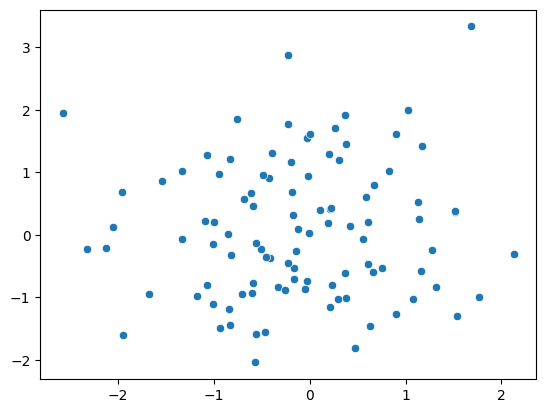

4/4 [==============================] - 1s 183ms/step


In [117]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate poitns in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
# def interpolate_points(p1, p2, n_steps=10):
#     # interpolate ratios between the points
#     ratios = linspace(0, 1, num=n_steps)
#     # linear interpolate vectors
#     vectors = list()
#     for ratio in ratios:
#         v = (1.0 - ratio) * p1 + ratio * p2
#         vectors.append(v)
#     return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
    plt.figure(figsize=(16,16))
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.savefig('generated_faces2.png')
    plt.close()
    # plt.show()

# load_model
model = load_model('training_data/models/generator_model_100.0.h5')

# # generate points in latent space
# n = 20

# # generate poitns in latent space
# pts = generate_latent_points(100, n)

# # interpolate pairs
# results = None
# for i in range(0, n, 2):
#     # interpolate points in latent space
#     interpolated = interpolate_points(pts[i], pts[i+1])
#     # generate images
#     X = model.predict(interpolated)
#     # scale from [-1,1] to [0,1]
#     X = (X + 1) / 2.0
#     if results is None:
#         results = X
#     else:
#         results = vstack((results, X))

# # plot the result
# plot_generated(results, 10)

# ==== INSERTED

# generate latent vectors to be used as input to the generator
#Here, we are generating 100 latent vectors
latent_points = generate_latent_points(100, 100)

import seaborn as sns
sns.scatterplot(x=latent_points[0], y=latent_points[1])
plt.show()

# generate images using the loaded generator model
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1] for plotting
X = (X + 1) / 2.0
# plot the generated images. Let us do 10x10 plot as we generated 100 images
plot_generated(X, 10)

# ==== INSERTED

In [11]:
print(latent_points)

[[ 1.58305268  0.98639145 -0.76690212 ... -0.23362402  1.40104079
   1.35112696]
 [ 0.72546758 -1.47056851  1.37816211 ... -0.34492273 -0.25292698
   0.50093073]
 [-0.59041694 -1.13464401 -1.18391384 ...  0.56062875 -2.24948933
  -0.06855851]
 ...
 [ 0.35015128 -0.67568092 -0.68448091 ...  0.80986802  0.28192552
   0.27831724]
 [-0.43017024  0.85579596 -0.30971816 ... -0.71455351  0.84063079
  -2.68811087]
 [-0.20437447 -0.19627369 -0.40909801 ... -1.2277053  -0.27001785
  -0.40934381]]


In [68]:
# save latent points to .txt
from numpy import savetxt
savetxt('latent_points.txt', latent_points)

In [116]:
import numpy as np
# Load the latent points from the .txt file
loaded_latent_points = np.loadtxt('latent_points.txt')
latent_points = loaded_latent_points

# Part 4 - Explore the Latent Space for Faces - with a target arithmetic

In [109]:
# example of loading the generator model and generating images

from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import hstack
from numpy import expand_dims
import numpy as np
import matplotlib.pyplot as plt

In [129]:
# average list of latent space vectors
def average_points(points, ix):
    # convert to zero offset points
    zero_ix = [i-1 for i in ix]
    # retrieve required points
    vectors = points[zero_ix]
    # average the vectors
    avg_vector = mean(vectors, axis=0)
    # combine original and avg vectors
    # all_vectors = vstack((vectors, avg_vector))
    return avg_vector

# create a plot of generated images
def plot_generated(examples, rows, cols):
    # plot images
    for i in range(rows * cols):
        # define subplot
        pyplot.subplot(rows, cols, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])

    pyplot.show()

1/1 [==============================] - 0s 173ms/step


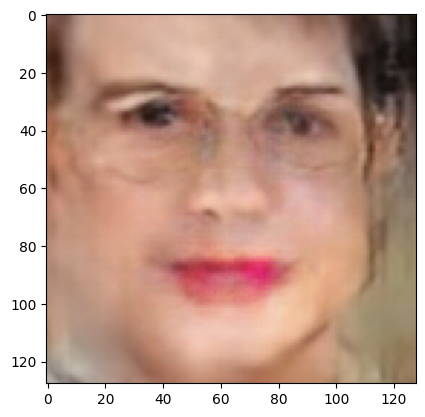

In [148]:
# load model
model = load_model('training_data/models/generator_model_100.0.h5')

# # retrieve specific points
# smiling_woman_ix = [92, 98, 99]
# neutral_woman_ix = [9, 21, 79]
# neutral_man_ix = [10, 30, 45]

# # load the saved latent points
# data = load('img_align_celeba.npz')
# points = data

# # average vectors
# smiling_woman = average_points(points, smiling_woman_ix)
# neutral_woman = average_points(points, neutral_woman_ix)
# neutral_man = average_points(points, neutral_man_ix)

# # combine all vectors
# all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))

# # generate images
# images = model.predict(all_vectors)

# # scale pixel values
# images = (images + 1) / 2.0
# plot_generated(images, 3, 4)

# # smiling woman - neutral woman + neutral man = smiling man
# result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

# # generate image
# result_vector = exp

# ==== INSERTED

# Identify a few images from classes of interest
# smiling_man_ix = [6, 9, 13, 52, 55, 91]
# neutral_man_ix = [31, 43, 45, 64]
# baby_ix = [13,26,28,93,94]
adult_with_glasses = [10, 47, 50, 68, 77, 78, 87]
adult_no_glasses = [8, 39, 79, 82, 86, 90, 95, 98]
#baby_no_glasses = [15,20]
person_with_lipstick = [15, 34, 48, 73, 77, 95]
#person_no_lipstick = [1, 9, 17, 31, 37, 47, 91]

#Reassign classes of interest to new variables... just to make it easy not
# to change names all the time we get interested in new features. 
feature1_ix = adult_with_glasses
feature2_ix = adult_no_glasses
feature3_ix = person_with_lipstick

# feature1_ix = smiling_man_ix
# feature2_ix = neutral_man_ix
# feature3_ix = person_with_lipstick

# average vectors for each class
feature1 = average_points(latent_points, feature1_ix)
feature2 = average_points(latent_points, feature2_ix)
feature3 = average_points(latent_points, feature3_ix)

# Vector arithmetic.... - with glasses and with lipstick
result_vector = feature1 + feature2 + feature3

# generate image using the new calculated vector
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)

# scale pixel values for plotting
result_image = (result_image + 1) / 2.0
plt.imshow(result_image[0])
plt.show()

# ==== INSERTED